# Standardizing PGAM fits
--------------------------------------

In this notebook we propose a pipeline for fitting PGAMs with standard input and output formats. The procedure has the following advantages:

1. It requires minimal coding (formatting the input data in a standard format)
2. The output fomat is easily exportable in MATLAB
3. The pipeline is comppatible with the PGAM docker image
4. The pipleine can be easily parallelized for HPC usage (singularity containers)


## Table of contents
* [Standard input format](#standard-input-format)
    * [Neural & behavioral inputs](#inputs)
    * [Configuration files](#configuration-files)
* [Example with synthetic data](#example-with-synthetic-data)
    * [Create and save an example configuration file](#create-and-save-conf)
    * [Fittng the model](#fitting-model)
        * [List the fits by experiment, condition, neuron, and model configuration](#fit-list)
        * [Load inputs, fit and postprocess](#load-fit-save)
* [Fit via docker](#docker)
    * [Mounting volumes](#mount-volumes)
    * [Setting paths](#container-path)
    * [Fit by running the container](#fit-container)
* [HPC & singularity ](#HPC)





## Standard input format <a name="standard-input-format"></a>

In order to fully specify the PGAM model we need:

1. A matrix containing the population spike counts (to be used as response variable and/or covariates)

2. A matrix containing the task variables (additional covariates)

3. A vector containing trial IDs

4. A list of covariates to be included and the ID of the unit that we want to fit.

5. The parameters defining a B-spline for each covariate (usually shared whithin a recording session or an entire experiment)
    
We propose the following standard input format to facilitate model specification, fitting and saving. 

### **Neural & behavioral inputs [1-4].** <a name="inputs"></a>

Inputs [1-4] will be contained in a single ".npz" files with keys: 

- **counts**: numpy.array of dim (T x N), where T is the total number of time points, N is the number of neurons
- **variables**: numpy.array of dim (T x M), T as above, M the number of task variables
- **trial_id**: numpy.array of dim T, trial ids associated to each time point
- **variable_names**: numpy.array of strings of dimension M, name of each covariate in 'variables'
- **neu_names**: numpy.array of strings of dimension N, label uniquely identifying the neurons in 'counts'
- **neu_info**: dict, *optional
    neu_info[neu_names[k]]: dict, info about the k-th neuron, $k=0,\dots,N-1$. keys are the information label.


### **Configuration files [5]**<a name="configuration-files"></a>

Input [5], the configuration parameters for the B-spline, will be stored with the "YAML" file format. Python dict objects can be readily saved in YAML format.





## Modelling synthetic data 

In the previous worksheet (Standardized_PGAM_1Simulation) we generated sample data from a neuron with known sensitivity to spatial and temporal inputs, as well as a configuration file that specifies how we're going to build the GAM.



### Load inputs, fit and postprocess <a name="load-fit-save"></a>

 
The code below: loads the input data, the configurations, fits the model, post-process and save the reuslts. The follwing lines of code are also saved as separate script in 'PGAM/utils/**fit_from_config.py**'

In [1]:
from pathlib import Path
import sys, os

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import savemat
import statsmodels.api as sm
import yaml

sys.path.insert(0, str(Path.cwd().parent/'PGAM'/'src'))

import GAM_library as gl
import gam_data_handlers as gdh
from post_processing import postprocess_results

path None do not exist
user not uses cuda
Module pycuda not found! Use CPU


In [2]:
# Settings
np.random.seed(4)

# frac of the trials used for fit eval
frac_eval = 0.2 

# PATH to fit list
path_fit_list = '/config/fit_B09_SRF.yml'

#### Loading Data

In [3]:
# load the job id (either as an input form the command line, or as a default value if not passed)
argv = sys.argv
if len(argv) == 2: # assumes the script is run the command "python fit_from_config.py fit_num"
    fit_num = int(sys.argv[1]) - 1 # HPC job-array indices starts from 1.
else:
    fit_num = 0 # set a default value

In [4]:
# load fit info about experiments to perform
with open(path_fit_list, 'r') as stream:
    fit_dict = yaml.safe_load(stream)
    
# unpack the info and load the data
experiment_ID = fit_dict['experiment_ID'][fit_num]
session_ID = fit_dict['session_ID'][fit_num]
neuron_num = fit_dict['neuron_num'][fit_num]
path_to_input = fit_dict['path_to_input'][fit_num]
path_to_config = fit_dict['path_to_config'][fit_num]
path_out = fit_dict['path_to_output'][fit_num]

print('FIT INFO:\nEXP ID: %s\nSESSION ID: %s\nNEURON NUM: %d\nINPUT DATA PATH: %s\nCONFIG PATH: %s\n\n'%(
    experiment_ID,session_ID,neuron_num+1,path_to_input,path_to_config))

FIT INFO:
EXP ID: exp_1
SESSION ID: session_A
NEURON NUM: 1
INPUT DATA PATH: /input/SRF_pgam_B09.npz
CONFIG PATH: /config/config_SRF_B09.yml




In [5]:
# Load & unpack spike counts and input variables that may be associated with spiking 
data = np.load(path_to_input, allow_pickle=True)

counts = data['counts']
variables = data['variables']
variable_names = data['variable_names']
neu_names = data['neu_names']
trial_ids = data['trial_ids']

if 'neu_info' in data.keys():
    neu_info = data['neu_info'].all()
else:
    neu_info = {}
    
# Load configuration information about how to fit each variable in the loaded data
with open(path_to_config, 'r') as stream:
    config_dict = yaml.safe_load(stream)

### Model Fitting

First create a train / evaluation split for the data

In [7]:
# create a train and eval set (approximately with the right frac of trials)
train_trials = trial_ids % (np.round(1/frac_eval)) != 0
eval_trials = ~train_trials

train_trials.mean()

0.8001644736842105

Now create an object for handling the smooth functions associated with each variable

In [8]:
sm_handler = gdh.smooths_handler()

for var in config_dict.keys():
    print('adding %s...'%var)
    
    # check if var is a neuron or a variable
    if var in variable_names:
        x_var = np.squeeze(variables[:, np.array(variable_names) == var])
    elif var in neu_names:
        x_var = np.squeeze(counts[:, np.array(neu_names) == var])
    else:
        raise ValueError('Variable "%s" not found in the input data!'%var)
    
    knots = config_dict[var]['knots']
    
    if np.isscalar(knots):
        knots = None
    else:
        knots = [np.array(knots)]

    lam = config_dict[var]['lam']
    der = config_dict[var]['der']
    order = config_dict[var]['order']  
    is_cyclic = config_dict[var]['is_cyclic']
    knots_num = config_dict[var]['knots_num']
    samp_period = config_dict[var]['samp_period']
    penalty_type = config_dict[var]['penalty_type']
    kernel_length = config_dict[var]['kernel_length']
    kernel_direction = config_dict[var]['kernel_direction']
    is_temporal_kernel = config_dict[var]['is_temporal_kernel']
    
    
    # rename the variable as spike hist if the input is the spike counts of the neuron we are fitting
    if var == neu_names[neuron_num]:
        label = 'spike_hist'
    else:
        label = var
    
    sm_handler.add_smooth(label, [x_var], knots=knots, ord=order, is_temporal_kernel=is_temporal_kernel,
                     trial_idx=trial_ids, is_cyclic=is_cyclic, penalty_type=penalty_type, der=der, lam=lam,
                         knots_num=knots_num, kernel_length=kernel_length,kernel_direction=kernel_direction,
                         time_bin=samp_period)

adding h2s_theta...
adding neuron_B09...


Now create the pgam model

In [9]:
link = sm.genmod.families.links.log()
poissFam = sm.genmod.families.family.Poisson(link=link)

spk_counts = np.squeeze(counts[:, neuron_num])

pgam = gl.general_additive_model(
    sm_handler,
    sm_handler.smooths_var, # list of coovarate we want to include in the model
    spk_counts,             # vector of spike counts
    poissFam                # poisson family with exponential link from statsmodels.api
)

### Fitting

In [10]:
print('\nfitting neuron %s...\n'%neu_names[neuron_num])
full, reduced = pgam.fit_full_and_reduced(sm_handler.smooths_var, 
                                          th_pval = 0.001,# pval for significance of covariate inclusion
                                          max_iter = 10 ** 2, # max number of iteration
                                          use_dgcv = True, # learn the smoothing penalties by dgcv
                                          trial_num_vec = trial_ids,
                                          filter_trials = train_trials)  


fitting neuron neuron_B09...



/PGAM/src/PGAM/GAM_library.py:107: RuntimeWarning: invalid value encountered in true_divide
  tuning = tuning / count_bins
/PGAM/src/PGAM/GAM_library.py:108: RuntimeWarning: invalid value encountered in true_divide
  sc_based_tuning = sc_based_tuning / count_bins
/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:2246: RuntimeWarning: invalid value encountered in _entropy (vectorized)
  outputs = ufunc(*inputs)
/PGAM/src/PGAM/GAM_library.py:121: RuntimeWarning: invalid value encountered in true_divide
  prob_s = count_bins / count_bins.sum()


#### Post-processing

Each row of **res** contains the info about a variable; some information is shared for all the variables (p-r squared, for example is a goodness-of-fit measure for the overall model), while other, like the parameters of the b-splines, are variable specific.

In [11]:
print('post-process fit results...')
res = postprocess_results(
    neu_names[neuron_num], 
    spk_counts, 
    full, 
    reduced, 
    train_trials,
    sm_handler, 
    poissFam, 
    trial_ids, 
    var_zscore_par=None, 
    info_save=neu_info, 
    bins=100)

post-process fit results...
processing:  h2s_theta
hstack: 0.0012973409902770072 sec
processing:  spike_hist


/PGAM/src/PGAM/post_processing.py:758: RuntimeWarning: Mean of empty slice
  tuning[ii] = np.nanmean(lam_s[idx])
/PGAM/src/PGAM/post_processing.py:759: RuntimeWarning: Mean of empty slice.
  sc_based_tuning[ii] = spk[filter_trials][idx].mean()
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/PGAM/src/PGAM/post_processing.py:1172: RuntimeWarning: invalid value encountered in true_divide
  rate_DT = rate_DT / tp_DT
/PGAM/src/PGAM/post_processing.py:1173: RuntimeWarning: invalid value encountered in true_divide
  counts_DT = counts_DT / tp_DT
/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:2246: RuntimeWarning: invalid value encountered in _entropy (vectorized)
  outputs = ufunc(*inputs)
/PGAM/src/PGAM/post_processing.py:636: RuntimeWarning: invalid value encountered in true_divide
  prob_s = count_bins / count_bins.sum()


Let's take a more detailed look at the results object - a numpy structured array

#### Plot the results

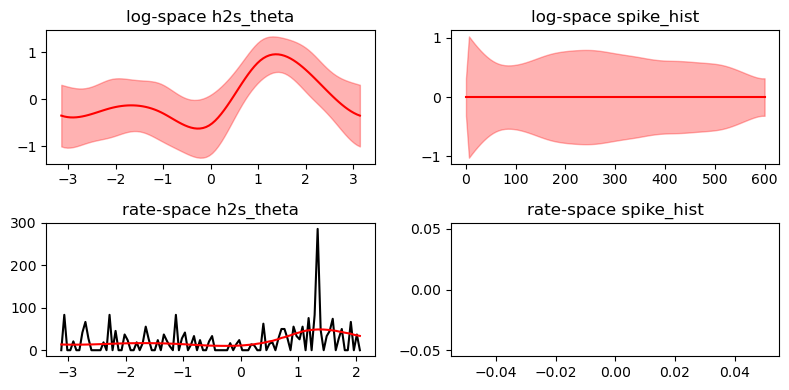

In [12]:
import matplotlib.pyplot as plt
# plot tuning functions
plt.figure(figsize=(8,4))

nvars = len(res)

for k in range(nvars):
    plt.subplot(2,nvars,k+1)
    plt.title('log-space %s'%res['variable'][k])
    x_kernel = res['x_kernel'][k]
    y_kernel = res['y_kernel'][k]
    ypCI_kernel = res['y_kernel_pCI'][k]
    ymCI_kernel = res['y_kernel_mCI'][k]
    
    plt.plot(x_kernel, y_kernel, color='r')
    plt.fill_between(x_kernel, ymCI_kernel, ypCI_kernel, color='r', alpha=0.3)
    
    
    
    x_firing = res['x_rate_Hz'][k]
    y_firing_model = res['model_rate_Hz'][k]
    y_firing_raw = res['raw_rate_Hz'][k]
    
    plt.subplot(2,nvars,k+nvars+1)
    plt.title('rate-space %s'%res['variable'][k])
    
    plt.plot(x_firing, y_firing_raw, color='k',label='raw')
    plt.plot(x_firing, y_firing_model, color='r',label='model')
    
#     plt.legend()
plt.tight_layout()

#### Plot radial SRF

In [25]:
# Get data from model
idx = [i for i, x in enumerate(list(res['variable'])) if x == 'h2s_theta']
idx = idx[0]

x_firing = res['x_rate_Hz'][idx]
y_firing_model = res['model_rate_Hz'][idx]
y_firing_raw = res['raw_rate_Hz'][idx]

# Wrap ends
x_firing = np.append(x_firing, x_firing[0])
y_firing_raw = np.append(y_firing_raw, y_firing_raw[0])
y_firing_model = np.append(y_firing_model, y_firing_model[0])

In [76]:
# Get raw data from input 
raw_theta = variables[:,0]
raw_rho = counts[:,0] / config_dict['h2s_theta']['samp_period']

# Add jitter to see datapoints
jitter = np.random.randn(raw_rho.shape[0]) / 10
raw_rho += jitter

In [75]:
jitter = np.random.randn(raw_rho.shape[0]) / 10
jitter.min()

-0.31617159615997714

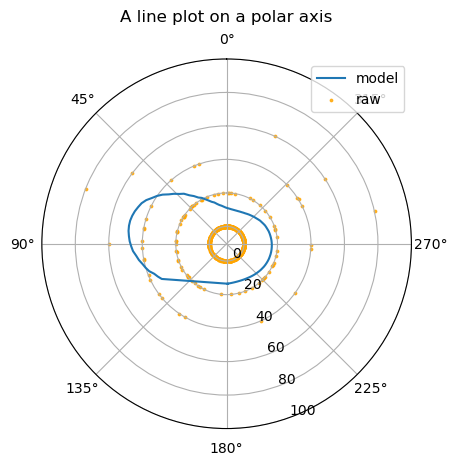

In [86]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

ax.plot(x_firing, y_firing_model, label='model')
ax.scatter(raw_theta, raw_rho, s=3, alpha=0.8, color='orange',label='raw')

ax.set_rmax(100)
# ax.set_rmin(0)
ax.set_rlabel_position(200)  # Move radial labels away from plotted line
ax.grid(True)
ax.legend()
ax.set_title("A line plot on a polar axis", va='bottom')
ax.set_theta_offset(np.pi/2)

plt.show()

##### Save the results

File name format: save_name will be expID_sessionID_neuID_configName

In [ ]:
config_basename = os.path.basename(path_to_config).split('.')[0]
save_name = '%s_%s_%s_%s'%(experiment_ID, session_ID, neu_names[neuron_num], config_basename)


np.savez(os.path.join(path_out, save_name+'.npz'), results=res)

# Fit via docker <a name="docker"></a>


Start docker. Make sure that you have the PGAM docker image by listing all available imagegs with the terminal command,
```sh
    docker images
```
It should list a repository named edoardobalzani87/pgam, 

```
REPOSITORY              TAG       IMAGE ID       CREATED          SIZE
edoardobalzani87/pgam   1.0       052c7daf6ff7   19 minutes ago   4.64GB

```

### Running the container and mounting volumes <a name="mount-volumes"></a>

If you are running the PGAM image in a docker container for fitting the model you must specify which of the host folders (e.g. the folders of the operating system running the container) will be mounted as volumes by the container. This is a necessary step if the container needs to read from or write into the host file system. The syntax of the command is the following,

```sh
    docker run -v <path to local folder 1>:<path to image folder 1> \
               -v <path to local folder 2>:<path to image folder 2> \
               ...
               -ti <docker image to be run> <command> -c "<additional commands>"
```

More specifically, mounting a folder means that: 1) when the container is started, the content of *\<local folder i>* in the file system of the host will be copied in *\<image folder i>* of the container temporary file system, 2) whenever the container writes in *\<image folder i>*  (saving/deleting files or cerating/deleting directories), the same will be performed on the host  *\<local folder i>*.  

The docker image has a few folders that one may use to mount local folders:

- **/input**: mount this container folder the host folder containing the input data and the fit list YAML file 
- **/output**: mount this container folder the host folder that will contain the output to be saved
- **/config**: mount this container folder the host folder containing the config YAML file
- **/scripts**: mount this container folder the host folder containing fitting script (fit_from_config.py)

### Setting paths <a name="container-path"></a>

Make sure to edit the fit list YAML file replacing host folders with container folders, for example:

```python
fit_dict = {
    'experiment_ID': ['exp_1'],
    'session_ID': ['session_A'],
    'neuron_num': [0],
    'path_to_input': ['input/example_data.npz'],         # 'input/', 'config/', and 'output/' are the path 
    'path_to_config': ['config/config_example_data.yml'] # to the folder in the temp file system 
    'path_to_output': ['output/']                        # of the container
}                                                        
# save the yaml fit list
with open('<path to local config folder>/fit_list_example_data.yml', 'w') as outfile:
    yaml.dump(fit_dict, outfile, default_flow_style=False)

```

Similarly edit the fit script that will load the fit list YAML, pointing the "config/" folder of the container. In "fit_from_config.py" we would need to set appropriately the variable "path_fit_list",

```python
...
#################################################
# User defined input
#################################################

# frac of the trials used for fit eval
frac_eval = 0.2 

# PATH to fit list
path_fit_list = 'input/fit_list_example_data.yml'
...
```

### Fit by running the container <a name="fit-container"></a>

Enter the following command in the terminal to create and run the container,

```sh
docker run -v <path to host input>:/input \
           -v <path to host output>:/output \
           -v <path to host config>:/config \
           -v <path to host scripts>:/scripts \
           -ti edoardobalzani87/pgam:1.0 bin/bash -c "python scripts/fit_from_config.py 0"

```

Delete delete unused containers by listing all the container with the command

```sh
docker ps -a
```

which will produce something similar to,
```sh
CONTAINER ID   IMAGE                       COMMAND                  CREATED              STATUS                     
3f3644b47861   edoardobalzani87/pgam:1.0   "bin/bash -c 'python…"   About a minute ago   Exited (0)
```

Reomve the container with,
```sh
docker rm <CONTAINER ID> 
```

Fit results will be stored in \<path to host output>.

# HPC & singularity <a name="HPC"></a>

This method is currently tested on the NYU green HPC. 
